<a href="https://colab.research.google.com/github/taipeihugo/20230205_python_byVictorGau/blob/main/1131122_%E5%8F%B0%E7%81%A3%E5%B0%B1%E6%A5%AD%E9%80%9A%E7%B6%B2%E7%AB%99%E8%81%B7%E7%BC%BA%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 ### 縣市代碼表:
 01 台北市 02 高雄市<br>
 11 基隆市 12 新竹市 13 台中市 14 嘉義市 15 台南市<br>
 23 金門縣 24 連江縣<br>
 31 新北市 32 宜蘭縣 33 桃園市 34 新竹縣 35 苗栗縣 36 台中縣 37 彰化縣 38 南投縣 39 雲林縣<br>
 40 嘉義縣 41 台南縣 42 高雄縣 43 屏東縣 44 澎湖縣 45 花蓮縣 46 台東縣<br>


---



In [ ]:
# @title 1.輸入「縣市代碼」及「職缺筆數」 {"form-width":"1px","display-mode":"code"}
import requests
import csv

# https://data.gov.tw/dataset/44062
# API 基本網址
url = "https://free.taiwanjobs.gov.tw/WebService_Taipei/Webservice.ashx?"

# 使用者輸入城市代碼與數量
city_code = '01, 02, 13, 15, 31, 33'  # @param ["01, 02, 13, 15, 31, 33"] {allow-input: true}
count = 1000  # @param {type:"slider", min:1, max:1000, step:1}
city_codes = [code.strip() for code in city_code.replace(',', ' ').split()] # 將字串分割為清單，支援空白或逗號分隔，刪除空白
#print(city_codes)
city_codes = list(set(city_codes)) # 確保代碼不重複
#print(city_codes)
cities = [{"CITY": code, "COUNT": count} for code in city_codes] # 構建查詢的城市清單
#print(cities)
all_jobs = [] # 初始化一個空的清單，用來存放所有工作的資料

# 定義一個函式，用來從簡單的 XML 格式中提取資料
def get_text(data, start_tag, end_tag):
    """
    從文字中找到特定標籤的內容，並去除可能存在的 CDATA 標籤
    """

    start = data.find(start_tag)
    end = data.find(end_tag)
    if start != -1 and end != -1:
        extracted_text = data[start + len(start_tag):end].strip()
        #print(extracted_text)
        extracted_text = extracted_text.replace("<![CDATA[", "").replace("]]>", "")
        #print(extracted_text)
        return extracted_text

    return ""

# 依序查詢每個城市
for city in cities:
    response = requests.get(url, params=city)
    #print(response)
    if response.status_code == 200:
        data = response.text
        # print(data)
        data_blocks = []
        start = 0
        while True:
            start = data.find("<Data>", start)
            if start == -1:
                break
            end = data.find("</Data>", start)
            if end != -1:
                data_blocks.append(data[start:end + len("</Data>")])
            start = end
        #print(data_blocks)
        # 逐個處理每個資料區塊
        for job_data in data_blocks:
            job = {
                "職位名稱": get_text(job_data, "<OCCU_DESC>", "</OCCU_DESC>"),
                "工作類型": get_text(job_data, "<WK_TYPE>", "</WK_TYPE>"),
                "工作地點": get_text(job_data, "<CITYNAME>", "</CITYNAME>"),
                "最低薪資": get_text(job_data, "<NT_L>", "</NT_L>"),
                "最高薪資": get_text(job_data, "<NT_U>", "</NT_U>"),
                "詳情連結": get_text(job_data, "<URL_QUERY>", "</URL_QUERY>"),
            }
            all_jobs.append(job)
    else:
        print(f"城市代碼 {city['CITY']} 的資料請求失敗")

# 儲存資料到 CSV 檔案
if all_jobs:
    with open("job.csv", "w", newline="", encoding="utf-8-sig") as file:
        writer = csv.DictWriter(file, fieldnames=["職位名稱", "工作類型", "工作地點", "最低薪資", "最高薪資", "詳情連結"])
        writer.writeheader()  # 寫入標題行
        for job_data in all_jobs:
            writer.writerow(job_data)  # 寫入每一行資料
    print("所有職缺資料已成功儲存為 'job.csv'")
else:
    print("未找到任何職缺資料，CSV 檔案未儲存。")

所有職缺資料已成功儲存為 'job.csv'




---



In [ ]:
# @title 2.統計各城市行政區的「職缺數」
import pandas as pd

# 讀取CSV檔案
url = 'job.csv'
data = pd.read_csv(url)

# 提取城市和行政區
data['城市'] = data['工作地點'].apply(lambda x: x.split('市')[0] + '市')
data['行政區'] = data['工作地點'].apply(lambda x: x.split('市')[1])

# 計算各城市各行政區的職缺數量
job_counts = data.groupby(['城市', '行政區']).size().reset_index(name='職缺數量')
#print(job_counts)
# 列出各城市及其行政區的職缺數量
current_city = None
print("各城市及其行政區的職缺數量：")
for _, row in job_counts.iterrows():
    if current_city != row['城市']:
        if current_city is not None:
            print()  # 在城市之間留空行
        print(f"===== {row['城市']} =====")
        current_city = row['城市']
    print(f"{row['行政區']}: {row['職缺數量']} 職缺")

In [ ]:
# @title 3.統計各城市行政區的「平均薪資」
import pandas as pd

# 讀取CSV檔案
url = 'job.csv'
data = pd.read_csv(url)

# 提取城市和行政區
data['城市'] = data['工作地點'].apply(lambda x: x.split('市')[0] + '市')
data['行政區'] = data['工作地點'].apply(lambda x: x.split('市')[-1])

# 將最低薪資和最高薪資轉換為數字型別，並處理缺失值
data['最低薪資'] = pd.to_numeric(data['最低薪資'], errors='coerce')
data['最高薪資'] = pd.to_numeric(data['最高薪資'], errors='coerce')

######## 原程式2024.11.22
# 計算平均薪資，並處理缺失值
####data['平均薪資'] = data[['最低薪資', '最高薪資']].mean(axis=1)

# 刪除包含NaN的行
####data = data.dropna(subset=['平均薪資'])
######## 原程式2024.11.22

#修改By Hsun
# 計算平均薪資，並處理缺失值
data['平均薪資'] = data[['最低薪資', '最高薪資']].mean(axis=1)

# 刪除包含NaN的行 和低於最低工資的資料(剔除兼職或不合理月薪) 2024最低基本工薪27470
data = data.dropna(subset=['平均薪資'])
data = data[data['平均薪資'] >= 27470]

####修改by Hsun


# 計算各城市各行政區的平均薪資
average_salary_by_city_district = data.groupby(['城市', '行政區'])['平均薪資'].mean().reset_index()
#print(average_salary_by_city_district)

# 列出各城市及其行政區的平均薪資
current_city = None
print("各城市及其行政區的平均薪資：")
for _, row in average_salary_by_city_district.iterrows():
    if current_city != row['城市']:
        if current_city is not None:
            print()  # 在城市之間留空行
        print(f"===== {row['城市']} =====")
        current_city = row['城市']
    # 取整數顯示平均薪資
    print(f"{row['行政區']}: {int(row['平均薪資'])} 元")

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


# 圖表

In [ ]:
# @title 2.安裝 Noto 字體
%%capture
!apt-get install -y fonts-noto-cjk &> /dev/null # 安裝 Noto 字體

請選擇要查看圓餅圖的城市：
1. 台中市
2. 台北市
3. 台南市
4. 新北市
5. 桃園市
6. 高雄市
請輸入城市編號：1


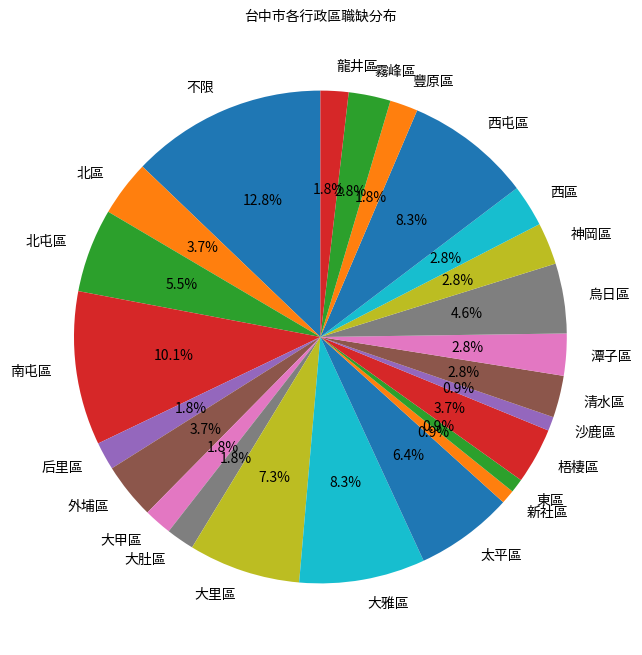

In [ ]:
# @title 3.統計縣市行政區「職缺數」（圓餅圖）
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # 確保路徑
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'cmss10'

# 讀取 CSV 檔案
url = 'job.csv'
data = pd.read_csv(url)

# 提取城市和行政區
data['城市'] = data['工作地點'].apply(lambda x: x.split('市')[0] + '市')
data['行政區'] = data['工作地點'].apply(lambda x: x.split('市')[1])
job_counts = data.groupby(['城市', '行政區']).size().reset_index(name='職缺數量')# 計算各城市各行政區的職缺數量
#print(data)
#print(job_counts)
cities = job_counts['城市'].unique() # 取得所有城市清單，刪去重複的城市
#print(cities)
# 提供城市選擇
print("請選擇要查看圓餅圖的城市：")
for i, city in enumerate(cities, start=1):
    print(f"{i}. {city}")

# 使用者選擇城市
city_index = int(input("請輸入城市編號：")) - 1
selected_city = cities[city_index]

# 過濾選定城市的資料
selected_city_data = job_counts[job_counts['城市'] == selected_city]

# 繪製圓餅圖
plt.figure(figsize=(8, 8))
plt.pie(
    selected_city_data['職缺數量'],
    labels=selected_city_data['行政區'],
    autopct='%1.1f%%',  # 顯示百分比
    startangle=90,  # 起始角度
    textprops={'fontproperties': font_prop}
)
plt.title(f"{selected_city}各行政區職缺分布", fontproperties=font_prop)
plt.show()



---



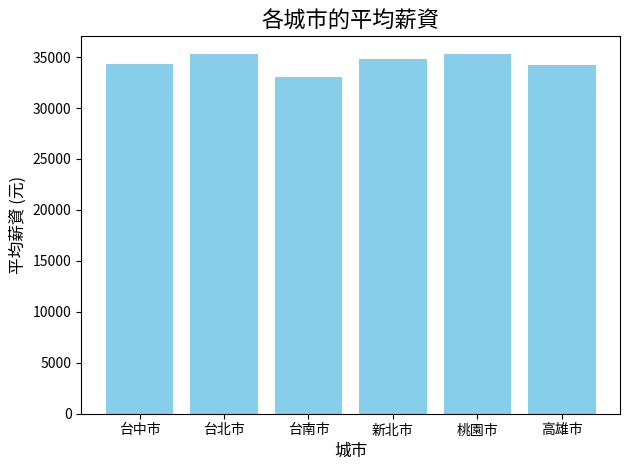

In [ ]:
# @title 4.統計縣市「平均薪資」（長條圖）
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 設置字體路徑與配置
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # 確保路徑正確
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False  # 確保負號顯示正常

# 讀取CSV檔案
url = 'job.csv'
data = pd.read_csv(url)

# 提取城市
data['城市'] = data['工作地點'].apply(lambda x: x.split('市')[0] + '市')
#print(data)
# 將最低薪資和最高薪資轉換為數字型別，並處理缺失值
data['最低薪資'] = pd.to_numeric(data['最低薪資'], errors='coerce')
data['最高薪資'] = pd.to_numeric(data['最高薪資'], errors='coerce')
data['平均薪資'] = data[['最低薪資', '最高薪資']].mean(axis=1)  # 計算平均薪資

# 刪除包含NaN的行
data = data.dropna(subset=['平均薪資'])
data = data[data['平均薪資'] >= 27470]

# 計算每個城市的平均薪資
average_salary_by_city = data.groupby('城市')['平均薪資'].mean().reset_index()
#print(data)
#print(average_salary_by_city)
# 繪製長條圖
plt.bar(average_salary_by_city['城市'], average_salary_by_city['平均薪資'], color='skyblue')

# 添加標題和標籤
plt.title("各城市的平均薪資", fontproperties=font_prop, fontsize=16)
plt.xlabel("城市", fontproperties=font_prop, fontsize=12)
plt.ylabel("平均薪資 (元)", fontproperties=font_prop, fontsize=12)

# 設定X軸字型
plt.xticks(fontproperties=font_prop, rotation=0)
plt.yticks(fontproperties=font_prop)

# 調整圖表外觀並顯示
plt.tight_layout()
plt.show()